In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from pylab import imread, imsave
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings("ignore")

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    gs = gridspec.GridSpec(nRows,nCols)
    gs.update(wspace =WidthSpace, hspace = HeightSpace) # Set the spacing between axes.
    plt.figure(figsize = (20,10))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        plt.subplot(nRows, nCols, i+1)
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')
    plt.show()
    

# Bai 1

* Chuyển đổi thành ảnh xám

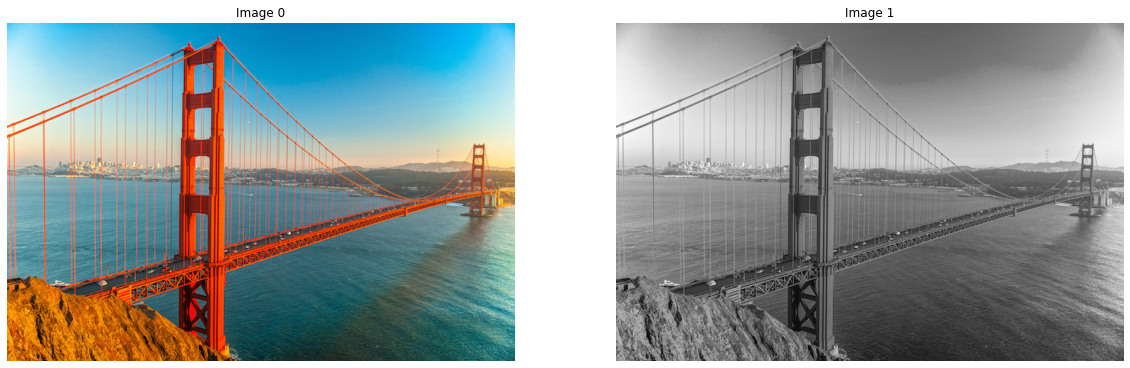

In [3]:
# Read Image
image_color = imread("Sample04/bridge.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color,image_gray], 1, 2)

In [4]:
def Image3Dto2D(image):
    if(len(image.shape) >= 3):
        image_2D = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_2D = image.copy()
    return image_2D

In [5]:
def DFT_Transformation(image):
    img = Image3Dto2D(image)
    img_float32 = np.float32(img)
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    return magnitude_spectrum, dft_shift

* Biến đổi DFT và hiển thị ảnh ở miền tần số

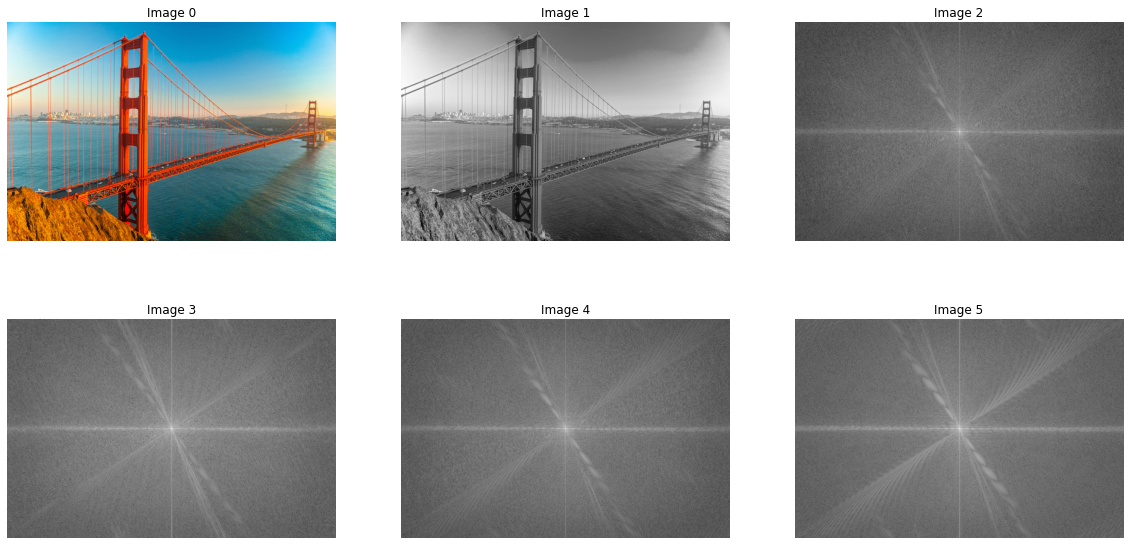

In [6]:
image_dft_frequency, dft_shift = DFT_Transformation(image_gray)
image_dft_frequency1, dft_shift1 = DFT_Transformation(image_color[:,:,0])
image_dft_frequency2, dft_shift2 = DFT_Transformation(image_color[:,:,1])
image_dft_frequency3, dft_shift3 = DFT_Transformation(image_color[:,:,2])
ShowImage([image_color, image_gray, image_dft_frequency, image_dft_frequency1, image_dft_frequency2, image_dft_frequency3], 2, 3)


* Thực hiện tạo ảnh mask để bỏ miền tần số cao và hiển thị ảnh texture

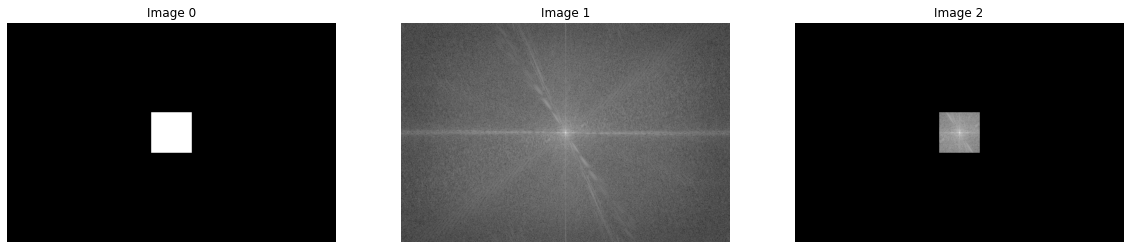

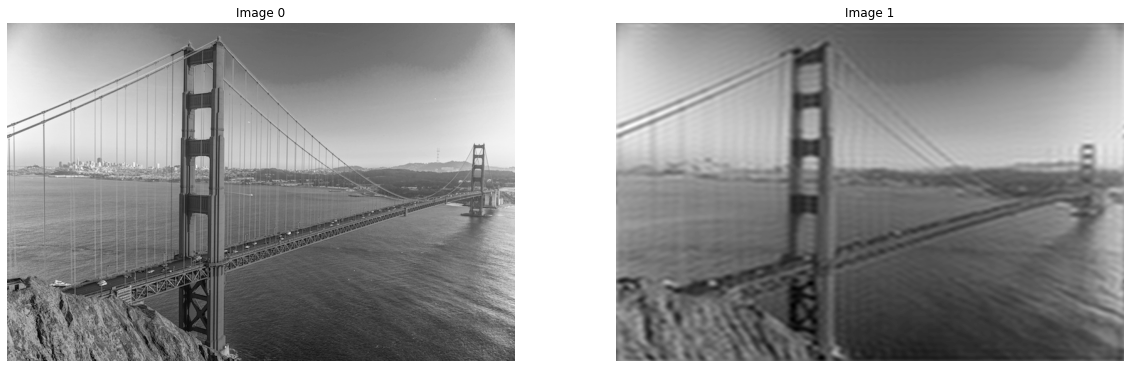

In [7]:
# Drop Frequency high
#____________________________________________
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows, cols, 2), np.uint8)

size = 50

mask[crow-size:crow+size, ccol-size:ccol+size] = 1
image_dft_frequency_crop = image_dft_frequency* mask[:,:,0]

# apply mask and inverse DFT

fshift = dft_shift*mask

f_ishift = np.fft.ifftshift(fshift)

img_inverse = cv2.idft(f_ishift)

image_inverse = cv2.magnitude(img_inverse[:,:,0],img_inverse[:,:,1])


# Show Image
ShowImage([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

* Thực hiện tạo ảnh mask để bỏ miền tần số thấp và hiển thị ảnh edge

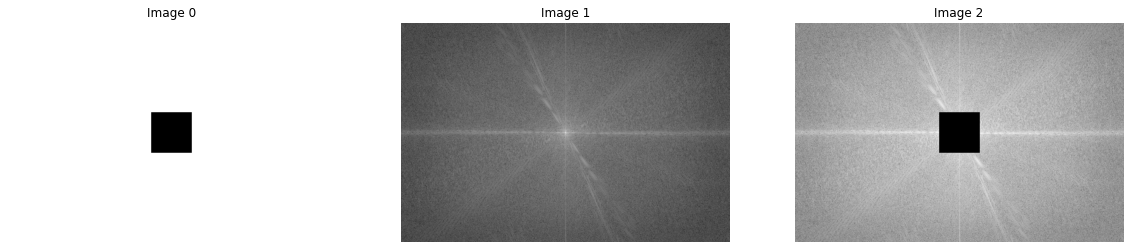

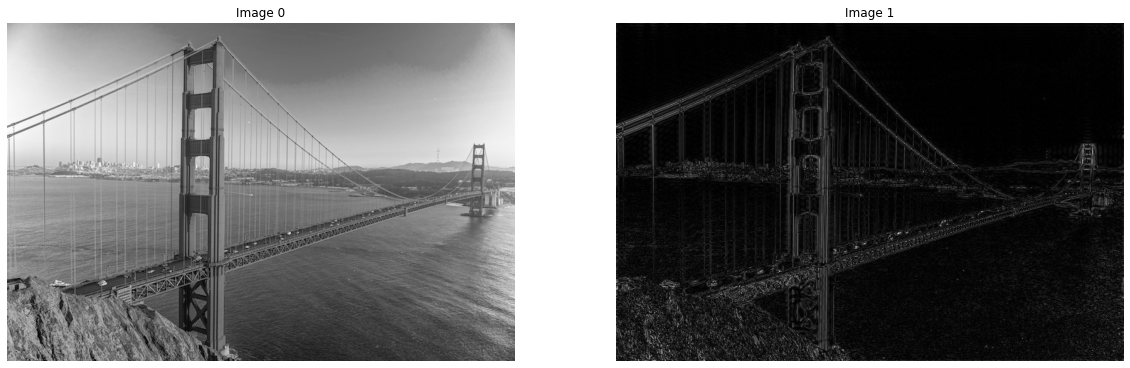

In [8]:
# Drop frequency low
#____________________________________________
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows, cols, 2), np.uint8)

size = 50

mask[crow-size:crow+size, ccol-size:ccol+size] = 1

mask = 1 - mask

image_dft_frequency_crop = image_dft_frequency* mask[:,:,0]

# apply mask and inverse DFT

fshift = dft_shift*mask

f_ishift = np.fft.ifftshift(fshift)

img_inverse = cv2.idft(f_ishift)

image_inverse = cv2.magnitude(img_inverse[:,:,0],img_inverse[:,:,1])


# Show Image
ShowImage([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

* Thực hiện tạo ảnh mask như sau và thực hiện thay đổi miền tần số sau đó xuất ảnh kết quả

In [9]:
# Change frequency
#____________________________________________
def drop_frequency(image_gray, style=1):
    rows, cols = image_gray.shape
    crow, ccol = rows//2, cols//2
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    if style:
        for x in np.arange(0, crow):
            d1 = (int)((x + 4*crow)*ccol/(5*crow))
            d2 = (int)((3*x + 2*crow)*ccol/(5*crow))
            mask[x, d2:d1] = 1
        for x in np.arange(crow, rows):
            d1 = (int)((x + 4*crow)*ccol/(5*crow))
            d2 = (int)((3*x + 2*crow)*ccol/(5*crow))
            mask[x, d1:d2] = 1
    else:
        for y in np.arange(0, ccol):
            d1 = (int)(((-1)*y + 4*ccol)*crow/(3*ccol))
            d2 = -d1
            mask[d2:d1, y] = 1
        for y in np.arange(ccol, cols):
            d1 = (int)(((-1)*y + 4*ccol)*crow/(3*ccol))
            d2 = -d1
            mask[d1:d2, y] = 1
    mask = 1 - mask
    image_dft_frequency_crop = image_dft_frequency*mask[:, :, 0]
    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_inverse = cv2.idft(f_ishift)
    image_inverse = cv2.magnitude(img_inverse[:,:,0], img_inverse[:,:,1])
    return mask, image_dft_frequency_crop, image_inverse



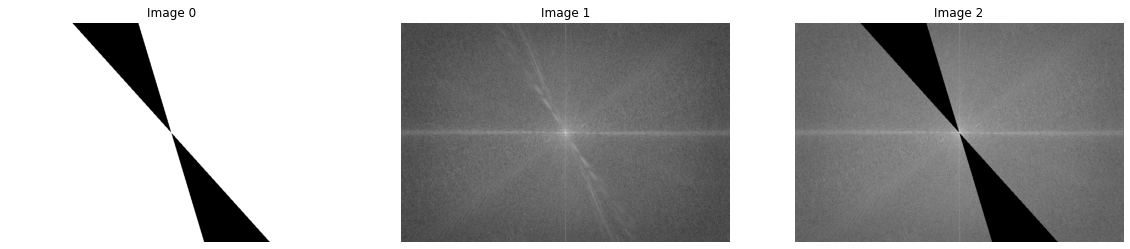

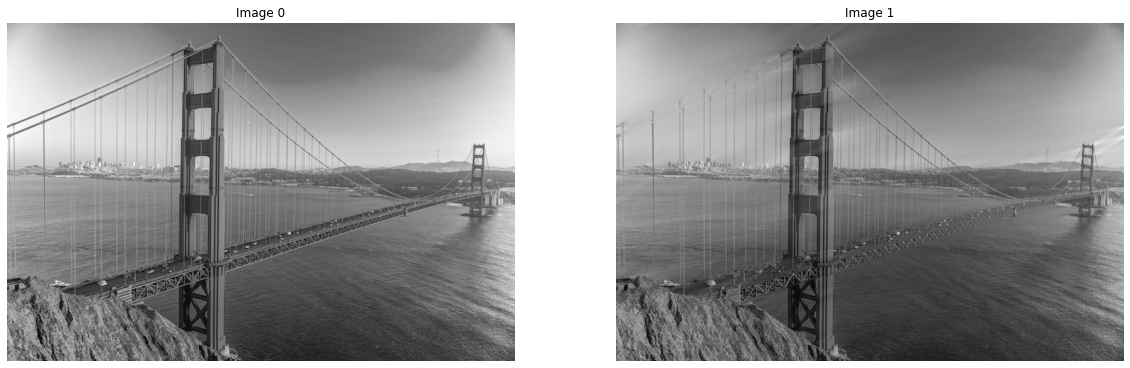

In [10]:
mask, image_dft_frequency_crop, image_inverse = drop_frequency(image_gray, style=1)
ShowImage([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

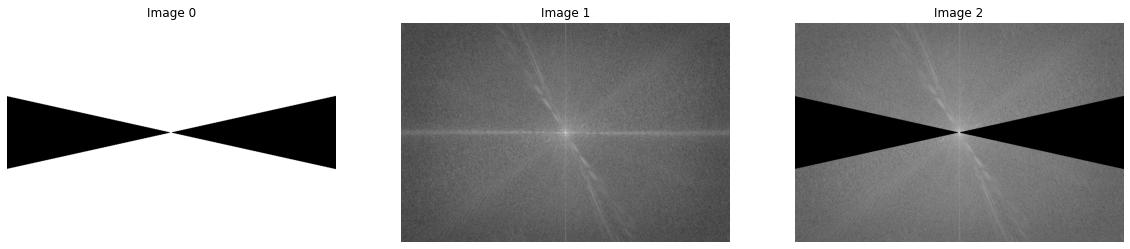

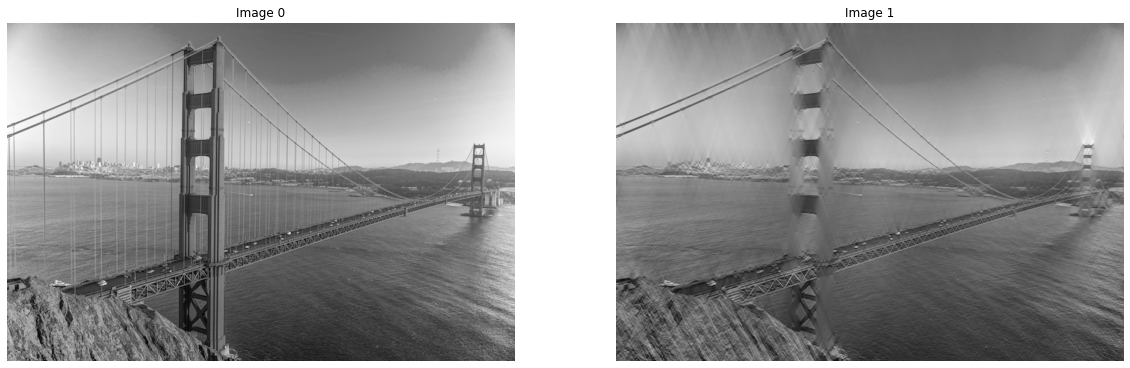

In [11]:
mask, image_dft_frequency_crop, image_inverse = drop_frequency(image_gray, style=0)
ShowImage([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

# Bai 2

* Chuyển đổi thành ảnh xám

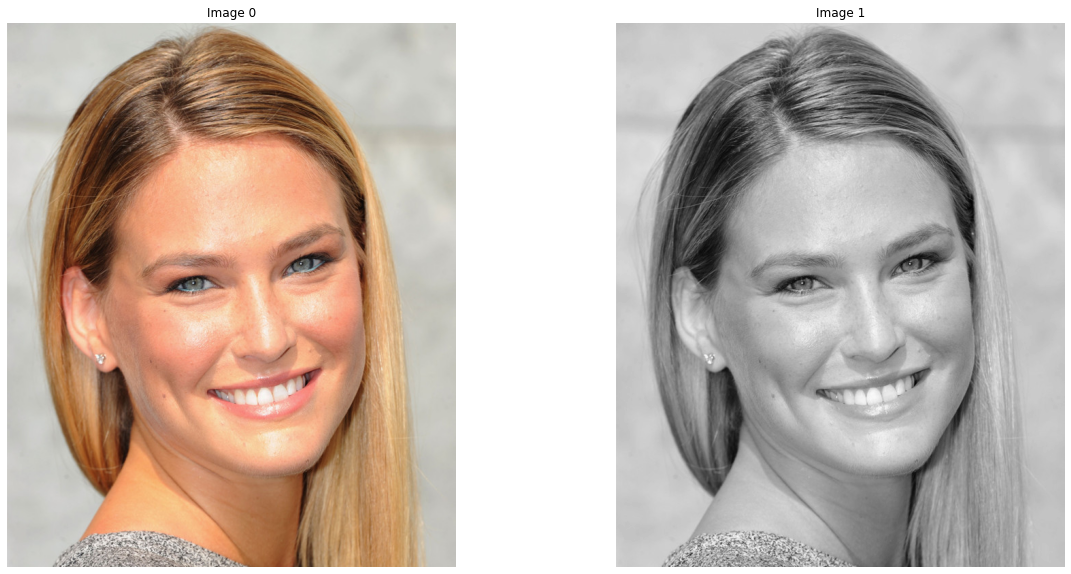

In [12]:
# Read Image
image_color = imread("Sample04/smile.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

In [13]:
import scipy.fftpack
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')


* Biến đổi DCT và hiển thị ảnh DCT

In [14]:
def Compress_image_DCT(image2D, threshold = 0.012):
    im = image2D
    imsize = im.shape
    dct = np.zeros(imsize)
    im_dct = np.zeros(imsize)
    # Do 8x8 DCT on image (in-place)
    for i in np.r_[:imsize[0]:8]:
        for j in np.r_[:imsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)] )
    # Threshold
    dct_thresh = dct * (abs(dct) > (threshold*np.max(dct)))
    percent_nonzeros = np.sum(dct_thresh != 0.0)/(imsize[0]*imsize[1]*1.0)
    # 8x8 iDCT
    for i in np.r_[:imsize[0]:8]:
        for j in np.r_[:imsize[1]:8]:
            im_dct[i:(i+8), j:(j+8)] = idct2(dct_thresh[i:(i+8), j:(j+8)])
    return percent_nonzeros, im_dct, dct, dct_thresh

def Compress_image_DFT(image2D, threshold = 0.013):
    im = image2D
    imsize = im.shape
    dft = np.zeros(imsize,dtype='complex');
    im_dft = np.zeros(imsize,dtype='complex');

    # 8x8 DFT
    for i in np.r_[:imsize[0]:8]:
        for j in np.r_[:imsize[1]:8]:
            dft[i:(i+8),j:(j+8)] = np.fft.fft2( im[i:(i+8),j:(j+8)] )

    # Thresh
    dft_thresh = dft * (abs(dft) > (threshold*np.max(abs(dft))))
    percent_nonzeros = np.sum( dft_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    # 8x8 iDFT
    for i in np.r_[:imsize[0]:8]:
        for j in np.r_[:imsize[1]:8]:
            im_dft[i:(i+8),j:(j+8)] = np.fft.ifft2( dft_thresh[i:(i+8),j:(j+8)] )
    return  percent_nonzeros, abs(im_dft), dft, dft_thresh



In [15]:
threshold = 0.0156
percent_nonzeros, im_dct, dct, dct_thresh = Compress_image_DCT(image_gray,threshold = threshold)

Text(0.5, 1.0, '8x8 DCTs of the image')

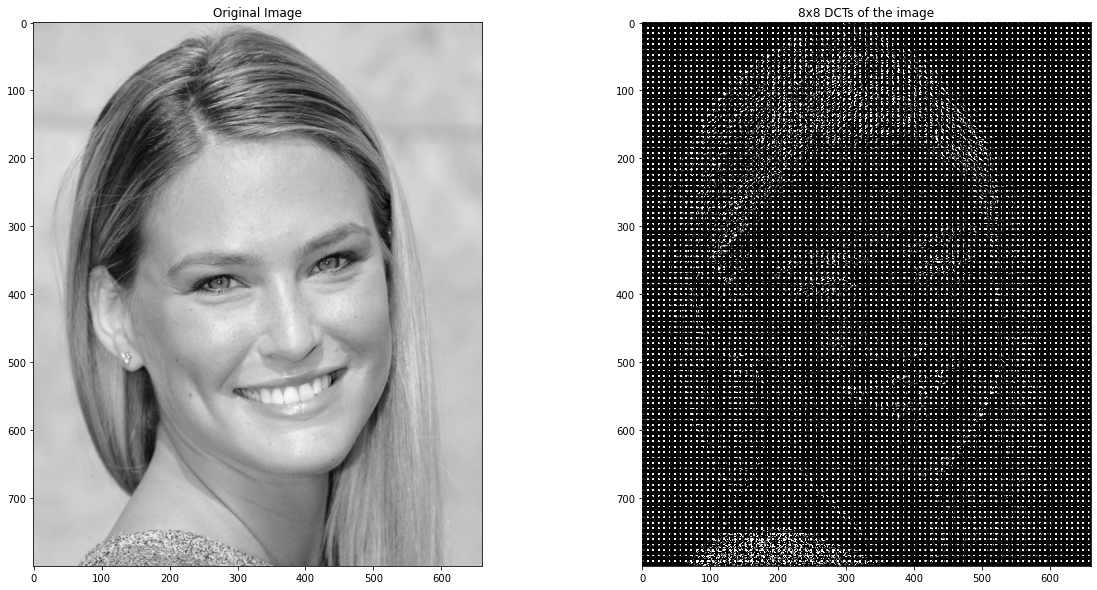

In [16]:
# DispLay entire DCT
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image_gray, cmap = 'gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(dct, cmap="gray",vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "8x8 DCTs of the image")

* Đặt ngưỡng giữ lại khoảng 5% hệ số DCT và hiển thị ảnh nén kết quả

Keeping only 3.820833% of the DCT coefficients
Comparison between orginal and DCT compressed images


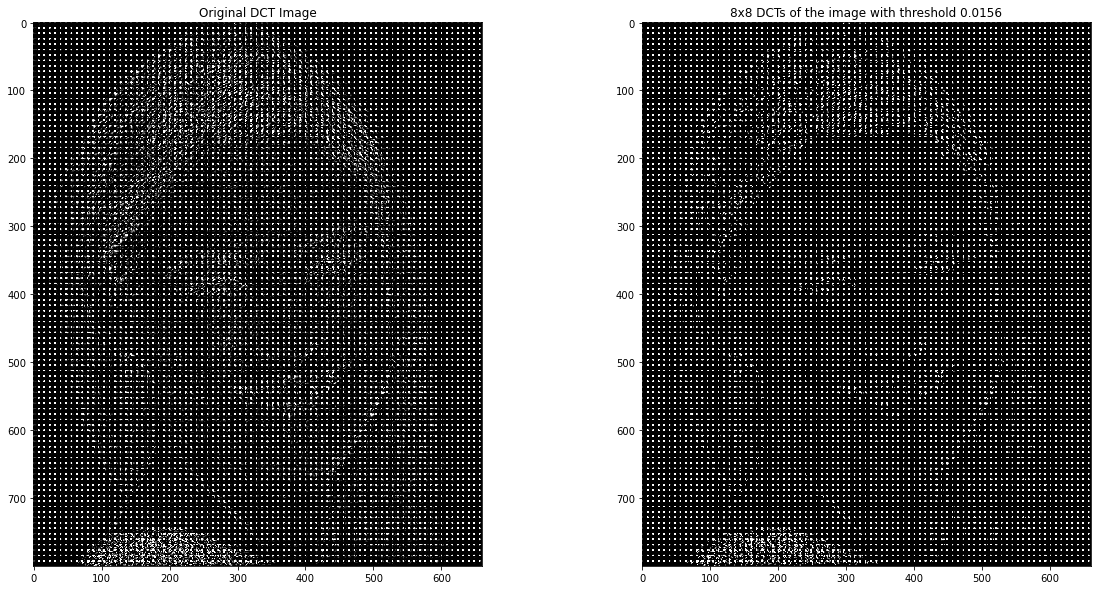

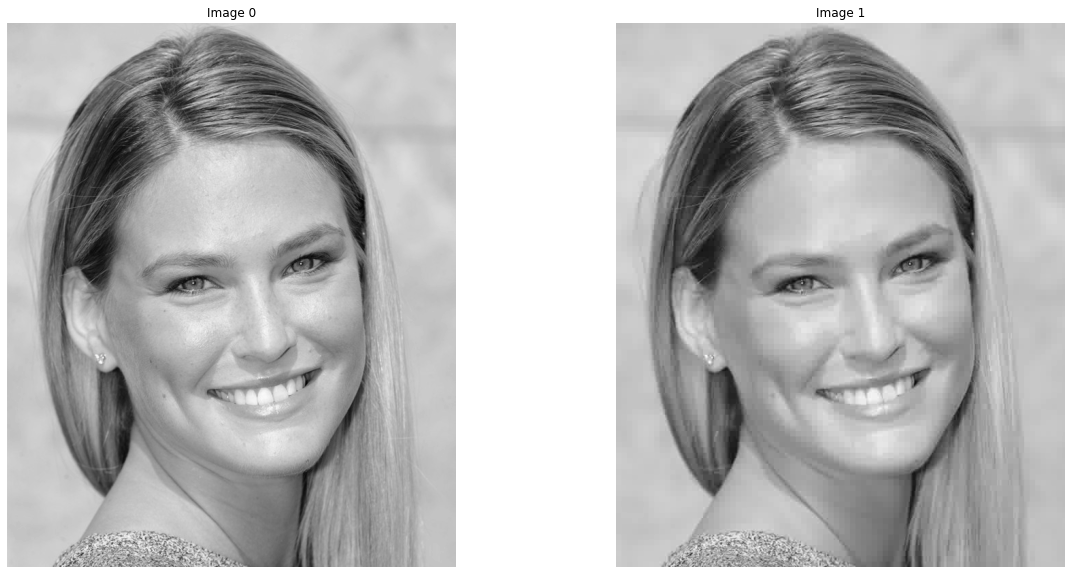

In [17]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(dct, cmap="gray",vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "Original DCT Image")
plt.subplot(1,2,2)
plt.imshow(dct_thresh, cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "8x8 DCTs of the image with threshold " + str(threshold))

print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
print("Comparison between orginal and DCT compressed images")
ShowImage([image_gray, im_dct],1,2)

# Bai 3

##### Kiếm một ảnh màu trên internet và thực hiện nén các ảnh này dùng DFT và DCT bằng cách giữ lại 5% hệ số. Sau đó khôi phục lại ảnh màu và lưu xuống thư mục cũng như xuất dung lượng ảnh xem giảm được bao nhiêu dung lượng (Gợi ý dùng không gian HSV nén V nhưng vẫn giữ được màu, thử nén H và S xem sao)

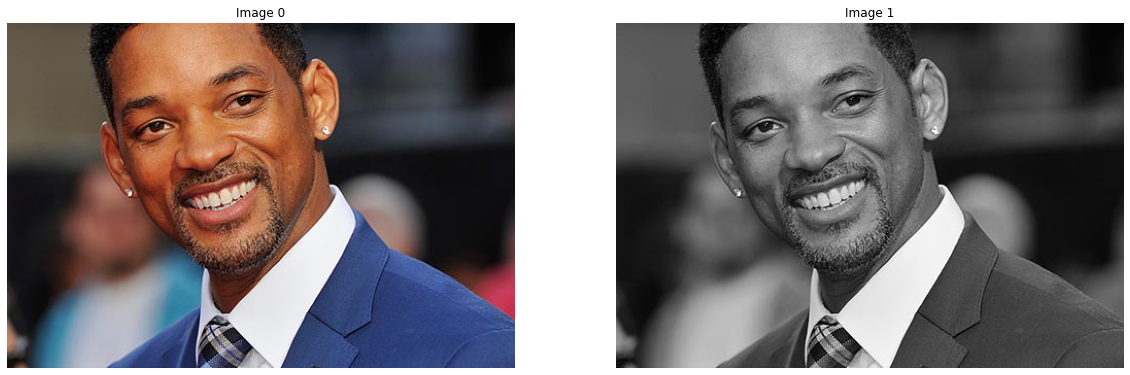

In [18]:
# Read Image
image_color = imread("Sample04/smile2.jpg")
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

In [19]:
# Compression H channel
im_H = image_hsv[:, :, 0]
threshold = 0.023
percent_nonzeros_dct_H, im_dct_H, dct_H, dct_thresh_H = Compress_image_DCT(im_H, threshold=threshold)
threshold = 0.028
percent_nonzeros_dft_H, im_dft_H, dft_H, dft_thresh_H = Compress_image_DFT(im_H, threshold=threshold)
print("Keeping only %f%% of the DCT coefficients by H channel" % (percent_nonzeros_dct_H*100.0))
print("Keeping only %f%% of the DFT coefficients by H channel" % (percent_nonzeros_dft_H*100.0))
print("*"*30)
# Compression S channel
im_S = image_hsv[:, :, 1]
threshold = 0.024
percent_nonzeros_dct_S, im_dct_S, dct_S, dct_thresh_S = Compress_image_DCT(im_S, threshold=threshold)
threshold = 0.027
percent_nonzeros_dft_S, im_dft_S, dft_S, dft_thresh_S = Compress_image_DFT(im_S, threshold=threshold)
print("Keeping only %f%% of the DCT coefficients by S channel" % (percent_nonzeros_dct_S*100.0))
print("Keeping only %f%% of the DFT coefficients by S channel" % (percent_nonzeros_dft_S*100.0))
print("*"*30)
# Compression V channel
im_V = image_hsv[:, :, 2]
threshold = 0.0161
percent_nonzeros_dct_V, im_dct_V, dct_V, dct_thresh_V = Compress_image_DCT(im_V, threshold=threshold)
threshold = 0.019
percent_nonzeros_dft_V, im_dft_V, dft_V, dft_thresh_V = Compress_image_DFT(im_V, threshold=threshold)
print("Keeping only %f%% of the DCT coefficients by V channel" % (percent_nonzeros_dct_V*100.0))
print("Keeping only %f%% of the DFT coefficients by V channel" % (percent_nonzeros_dft_V*100.0))

Keeping only 5.041930% of the DCT coefficients by H channel
Keeping only 5.009234% of the DFT coefficients by H channel
******************************
Keeping only 5.024977% of the DCT coefficients by S channel
Keeping only 4.945657% of the DFT coefficients by S channel
******************************
Keeping only 5.048591% of the DCT coefficients by V channel
Keeping only 5.024371% of the DFT coefficients by V channel


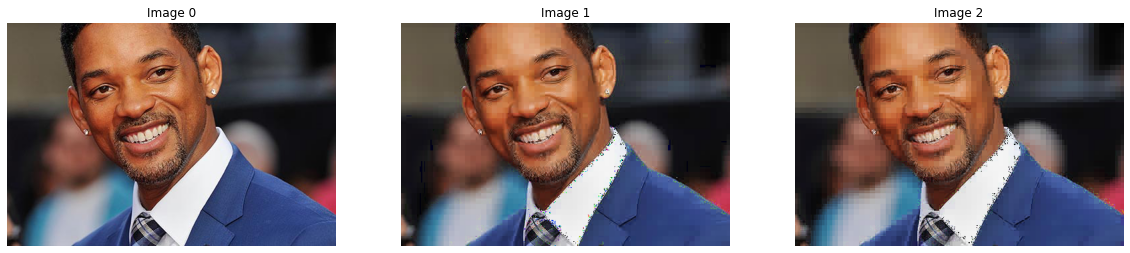

In [20]:
image_hsv[:, :, 0] = im_dct_H
image_hsv[:, :, 1] = im_dct_S
image_hsv[:, :, 2] = im_dct_V
img_compress_dct = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
image_hsv[:, :, 0] = im_dft_H
image_hsv[:, :, 1] = im_dft_S
image_hsv[:, :, 2] = im_dft_V
img_compress_dft = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
ShowImage([image_color, img_compress_dct, img_compress_dft], 1, 3)

* Lưu ảnh

In [21]:
path = 'Compress_Image_Output'
os.mkdir(path)
imsave(os.path.join(path, "dct_compress_image.jpg"), img_compress_dct)
imsave(os.path.join(path, 'dft_compress_image.jpg'), img_compress_dft)

In [22]:
path_original = 'Sample04/smile2.jpg'
path_dct = 'Compress_Image_Output/dct_compress_image.jpg'
path_dft = 'Compress_Image_Output/dft_compress_image.jpg'
size_original = os.path.getsize(path_original)
size_dct = os.path.getsize(path_dct)
size_dft = os.path.getsize(path_dft)
print("Size of original image: ", size_original)
print("Size of image after dct compressing: {}, decrease {}".format(size_dct, size_original-size_dct))
print("Size of image after dft compressing: {}, decrease {}".format(size_dft, size_original-size_dft))

Size of original image:  44665
Size of image after dct compressing: 16141, decrease 28524
Size of image after dft compressing: 15373, decrease 29292
